In [4]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn
import statistics


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from collections import OrderedDict
from sklearn.externals import joblib


C:\Users\Elise\AppData\Roaming\Python\Python37\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


### L'étude dure 2h30 soit 9000 s (validé par figure 1)
Chaque activité prend comme temps :
* Sitting 10 min -> 600 s
* Stairs 5 min -> 300 s
* Table Soccer 5min -> 300 s
* Cycling 8 min -> 480 s
* driving car 15 min -> 900 s
* Lunch break 30 min -> 1800 s
* Walking 1min -> 600 s
* Working 8 min -> 1200 s


Nous allons dans un premier temps étudier le sujet 7 afin de comparer à la figure 1

In [5]:
chemin = 'C:/Users/Elise/Documents/Esilv/5emeAnnee/PythonForDataAnalysis/Projet/PPG_FieldStudy/S7/S7.pkl'
data =  pd.read_pickle(chemin)

In [6]:
data

{'rpeaks': array([    633,    1428,    2197, ..., 6538533, 6539057, 6539681]),
 'signal': {'chest': {'ACC': array([[ 0.87160003,  0.02540004, -0.15560001],
          [ 0.87100005,  0.02260005, -0.15859997],
          [ 0.87020004,  0.02320004, -0.15899998],
          ...,
          [ 0.93079996, -0.06120002, -0.2062    ],
          [ 0.93060005, -0.0564    , -0.21259999],
          [ 0.93120003, -0.0546    , -0.21380001]]),
   'ECG': array([[ 0.12437439],
          [ 0.13188171],
          [ 0.13829041],
          ...,
          [-0.08843994],
          [-0.08757019],
          [-0.08258057]]),
   'EMG': array([[-1.5],
          [-1.5],
          [-1.5],
          ...,
          [-1.5],
          [-1.5],
          [-1.5]]),
   'EDA': array([[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]]),
   'Temp': array([[-273.15],
          [-273.15],
          [-273.15],
          ...,
          [-273.15],
          [-273.15],
          [-273.15

# 1) Analyse de données

In [7]:
print('Nombre de keys : ' + str(len(data.keys())) )
print('Nom des keys : ' + str(data.keys()))

Nombre de keys : 6
Nom des keys : dict_keys(['rpeaks', 'signal', 'label', 'activity', 'questionnaire', 'subject'])


In [8]:
print('Sujet : ' + str(data['subject']))
print('Caractéristique du sujet : '+ str(data['questionnaire']))

Sujet : S7
Caractéristique du sujet : {'WEIGHT': 58.0, 'Gender': ' f', 'AGE': 21, 'HEIGHT': 168.0, 'SKIN': 3, 'SPORT': 2}


### 1.1. Etude du label

Le label est les valeurs des battements de coeur mesurés sur 8 secondes avec 2 secondes de repos, reporté sur 1 min
La moyenne des battements par minute est : 86.68667454907391
Le nombre de battements minimum par minute est : 48.63469322902146
Le nombre de battements maximum par minute est : 152.9134108074917


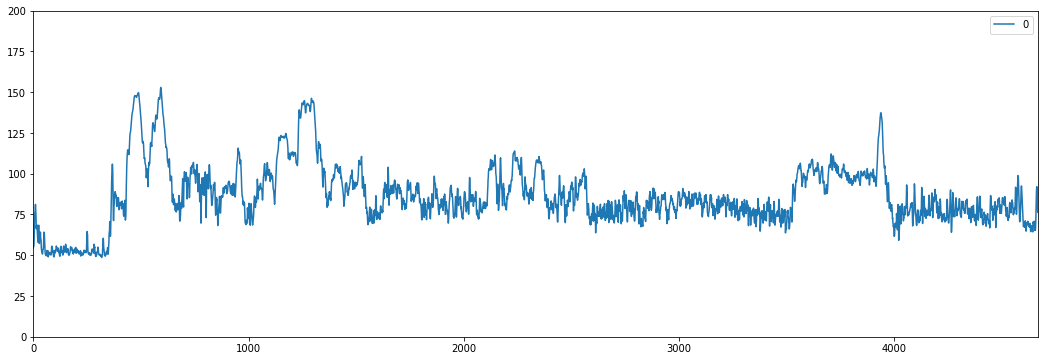

In [9]:
print('Le label est les valeurs des battements de coeur mesurés sur 8 secondes avec 2 secondes de repos, reporté sur 1 min')
print('La moyenne des battements par minute est : ' +str(data['label'].mean()))
print('Le nombre de battements minimum par minute est : ' +str(data['label'].min()))
print('Le nombre de battements maximum par minute est : ' +str(data['label'].max()))
dflabel = pd.DataFrame(data['label'])
dflabel.plot(yticks=range(0,225,25),figsize=(18,6))

### On met à l'échelle des 9000 s

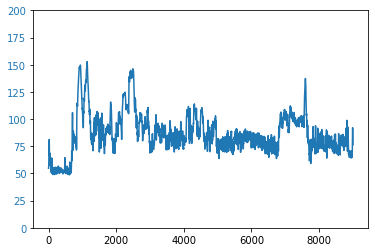

In [10]:
fig, ax = plt.subplots()

color = 'tab:blue'
ax.plot(dflabel.index*(9000/len(dflabel)), dflabel, color=color)
ax.tick_params(axis='y', labelcolor=color)
ax.set_yticks(range(0,225,25))
plt.show()

### 1.2. Etude de l'activité

On affiche le nombre de fois où on a réalisé l'activité : 
Transient periods(ID: 0)
Sitting (ID: 1)
Ascending and descending stairs (ID: 2)
Table soccer (ID: 3): Playing table soccer
Cycling (ID: 4)
Driving a car (ID: 5)
Lunch break (ID: 6)
Walking (ID: 7)
Working (ID: 8)


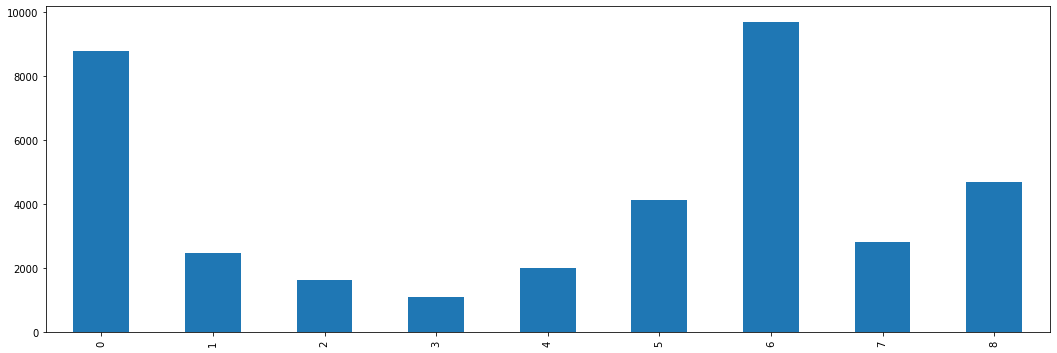

In [11]:
dfactivity = pd.DataFrame(data['activity'])
#On ajoute la colonne ci-après afin de pouvoir sommer
dfactivity['nb'] = 1
activity = dfactivity.groupby([0], as_index=False).sum()
print('On affiche le nombre de fois où on a réalisé l\'activité : ')
print('Transient periods(ID: 0)\nSitting (ID: 1)\nAscending and descending stairs (ID: 2)\nTable soccer (ID: 3): Playing table soccer\nCycling (ID: 4)\nDriving a car (ID: 5)\nLunch break (ID: 6)\nWalking (ID: 7)\nWorking (ID: 8)')
activity['nb'].plot(kind = "bar", figsize=(18,6))

### J'essaie de retrouver le même schéma que la figure 1 du ReadMe

In [12]:
print('Nombre de secondes que dure une activité : ' + str(9000/len(pd.DataFrame(data['activity']))))

Nombre de secondes que dure une activité : 0.24082200577972815


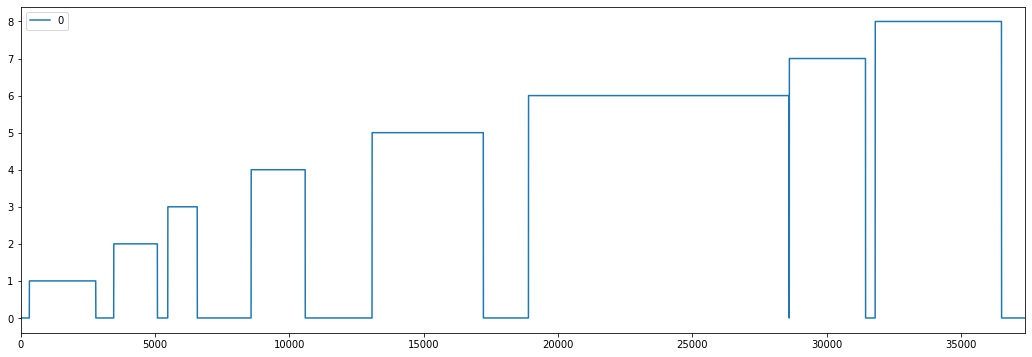

In [13]:
dfactivity = pd.DataFrame(data['activity'])
dfactivity.plot(figsize=(18,6))

### On met à l'échelle des 9000 s

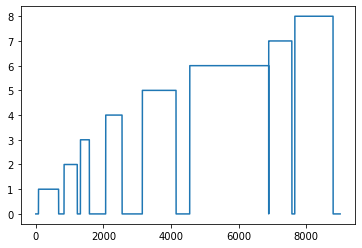

In [14]:
dfactivity = pd.DataFrame(data['activity'])
plt.plot(dfactivity.index*(9000/len(dfactivity)), dfactivity)

plt.show()

### 1.3. Etude du lien entre activity et label (figure 1 du ReadMe)

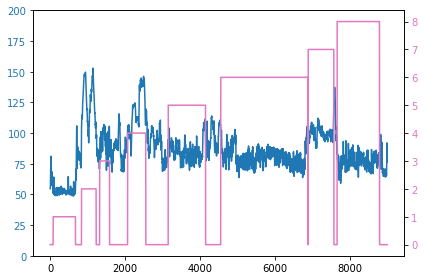

In [15]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.plot(dflabel.index*(9000/len(dflabel)), dflabel, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yticks(range(0,225,25))


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:pink'
ax2.plot(dfactivity.index*(9000/len(dfactivity)), dfactivity, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## 2. Création d'un dataframe regroupant tous les sujets

In [16]:
alldatas = {}
for i in range(1,16):
    print(i)
    alldatas[i] = pd.read_pickle(f"C:/Users/Elise/Documents/Esilv/5emeAnnee/PythonForDataAnalysis/Projet/PPG_FieldStudy/S"+str(i)+"/S"+str(i)+".pkl")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [17]:
pd.DataFrame(alldatas)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
activity,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
label,"[49.611369076105795, 50.323992482870175, 52.70...","[70.92296570347261, 71.29105527689472, 68.6938...","[52.904905990895365, 52.4832848965976, 53.5990...","[69.33133569178202, 74.23985397460334, 80.6865...","[96.0906143466522, 101.29797045926367, 108.862...","[105.03603052300089, 109.08819284696261, 111.7...","[54.71764132217654, 55.17330164858371, 55.3930...","[57.91516848266533, 59.1418718794675, 61.37444...","[66.60310756946997, 66.72622532983297, 67.1437...","[64.28235587205951, 63.349710123072235, 64.568...","[73.41463469471395, 78.43265402408036, 82.3741...","[54.98420867920524, 56.68301554508546, 58.1600...","[63.79889727455826, 65.42809985054454, 65.7692...","[72.6747289184089, 76.95480136227845, 73.42384...","[51.789772141788326, 53.95587356823631, 59.379..."
questionnaire,"{'WEIGHT': 78.0, 'Gender': ' m', 'AGE': 34, 'H...","{'WEIGHT': 80.0, 'Gender': ' m', 'AGE': 28, 'H...","{'WEIGHT': 60.0, 'Gender': ' m', 'AGE': 25, 'H...","{'WEIGHT': 57.0, 'Gender': ' m', 'AGE': 25, 'H...","{'WEIGHT': 70.0, 'Gender': ' f', 'AGE': 21, 'H...","{'WEIGHT': 70.0, 'Gender': ' f', 'AGE': 37, 'H...","{'WEIGHT': 58.0, 'Gender': ' f', 'AGE': 21, 'H...","{'WEIGHT': 70.0, 'Gender': ' m', 'AGE': 43, 'H...","{'WEIGHT': 60.0, 'Gender': ' f', 'AGE': 28, 'H...","{'WEIGHT': 56.0, 'Gender': ' f', 'AGE': 55, 'H...","{'WEIGHT': 62.0, 'Gender': ' f', 'AGE': 24, 'H...","{'WEIGHT': 105.0, 'Gender': ' m', 'AGE': 43, '...","{'WEIGHT': 63.0, 'Gender': ' f', 'AGE': 21, 'H...","{'WEIGHT': 67.0, 'Gender': ' f', 'AGE': 26, 'H...","{'WEIGHT': 79.0, 'Gender': ' m', 'AGE': 28, 'H..."
rpeaks,"[240, 1174, 2128, 3099, 3907, 4733, 5404, 6382...","[33, 700, 1316, 1932, 2536, 3094, 3661, 4220, ...","[337, 1103, 1897, 2673, 3496, 4295, 5103, 5901...","[206, 910, 1510, 2150, 2768, 3331, 3911, 4505,...","[71, 519, 976, 1440, 1874, 2331, 2783, 3225, 3...","[31, 464, 891, 1313, 1726, 2132, 2534, 2924, 3...","[633, 1428, 2197, 2971, 3739, 4507, 5241, 5963...","[217, 960, 1697, 2433, 3116, 3836, 4560, 5297,...","[486, 1161, 1829, 2473, 3095, 3709, 4291, 4886...","[560, 1194, 1851, 2503, 3168, 3800, 4448, 5137...","[553, 1181, 1804, 2417, 3009, 3591, 4121, 4655...","[669, 1496, 2303, 3089, 3838, 4552, 5267, 5989...","[226, 961, 1673, 2376, 2968, 3585, 4253, 4867,...","[7, 707, 1377, 2028, 2629, 3162, 3678, 4199, 4...","[506, 1267, 2097, 2945, 3778, 4607, 5380, 6170..."
signal,{'chest': {'ACC': [[ 0.85640001 -0.06779999 -0...,{'chest': {'ACC': [[0.91139996 0.03219998 0.05...,{'chest': {'ACC': [[ 0.90460002 -0.06120002 -0...,{'chest': {'ACC': [[ 0.90859997 -0.15979999 0...,{'chest': {'ACC': [[ 0.88940001 -0.25019997 -0...,{'chest': {'ACC': [[ 0.79540002 -0.167 -0...,{'chest': {'ACC': [[ 0.87160003 0.02540004 -0...,{'chest': {'ACC': [[ 0.90740001 -0.04100001 0...,{'chest': {'ACC': [[ 0.84739995 -0.00819999 -0...,{'chest': {'ACC': [[ 0.91760004 -0.01779997 -0...,{'chest': {'ACC': [[ 0.91779995 -0.0054 0...,{'chest': {'ACC': [[ 0.89100003 -0.01200002 -0...,{'chest': {'ACC': [[0.89300001 0.06099999 0.17...,{'chest': {'ACC': [[ 0.89300001 0.12619996 -0...,{'chest': {'ACC': [[ 0.86740005 0.16139996 -0...
subject,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15


Il est facile de mettre à l'échelle des 9000s pour un plot mais afin d'anticiper notre X pour la classification il faut que nous les mettions tous à l'échelle. Comme notre y sera activity et que celle-ci est à 4Hz on va tout ramener à 4 Hz.

Créons une fonction qui nous permettra de tout mettre à la bonne échelle

In [18]:
def mise_echelle_4H(datas, freq):
    temp = []
    nombre_division = int(freq / 4)
    
    for i in range(0, len(datas), nombre_division):
        temp.append((sum(datas[i:i+nombre_division]) / nombre_division))
    return temp

In [19]:
for k,v in alldatas.items():
    
    dfactivity = pd.DataFrame.from_dict(v["activity"])
    dfactivity.rename(columns={0:'activity'}, inplace=True)
    
    #On a besoin de répéter les données afin d'éviter les Nan 
    temp=v['label'].repeat(len(v['activity'])/len(v['label'])).tolist()
    #On obtient pas le bon nombre de valeur car il prend l'entier inférieur. 
    #Afin de ne pas fausser les valeurs on rajoute la moyenne des valeurs 
    temp.extend([statistics.mean(v['label'])] * (len(v['activity'])-len(temp)))
    dflabel = pd.DataFrame(temp)
    dflabel.rename(columns={0:'label'}, inplace=True)
    
    v["signal"]["chest"]["ECG"] = mise_echelle_4H(v["signal"]["chest"]["ECG"], 700)
    dfecg =pd.DataFrame.from_dict(v["signal"]["chest"]["ECG"])
    dfecg.rename(columns={0:'ecg'}, inplace=True)
    
    v["signal"]["chest"]["ACC"] = mise_echelle_4H(v["signal"]["chest"]["ACC"], 700)
    dfchestacc = pd.DataFrame.from_dict(v["signal"]["chest"]["ACC"])
    dfchestacc.rename(columns={0:'xchest',1:'ychest',2:'zchest'}, inplace=True)
    
    v["signal"]["chest"]["Resp"] = mise_echelle_4H(v["signal"]["chest"]["Resp"], 700)    
    dfresp=pd.DataFrame.from_dict(v["signal"]["chest"]["Resp"])
    dfresp.rename(columns={0:'resp'}, inplace=True)

    dfallchest = pd.concat([dfchestacc,dfecg , dfresp], axis=1)
    
    
    dftemp=pd.DataFrame.from_dict(v["signal"]["wrist"]["TEMP"])
    dftemp.rename(columns={0:'temp'}, inplace=True)
    
    v["signal"]["wrist"]["ACC"] = mise_echelle_4H(v["signal"]["wrist"]["ACC"], 32)
    dfwristacc = pd.DataFrame.from_dict(v["signal"]["wrist"]["ACC"])
    dfwristacc.rename(columns={0:'xwrist', 1:'ywrist', 2:'zwrist'}, inplace=True)
    
    v["signal"]["wrist"]["BVP"] = mise_echelle_4H(v["signal"]["wrist"]["BVP"], 64)
    dfbvp=pd.DataFrame.from_dict(v["signal"]["wrist"]["BVP"])
    dfbvp.rename(columns={0:'bvp'}, inplace=True )
    
    dfallwrist = pd.concat([dfwristacc, dfbvp, dftemp], axis=1)
    
    
    
    #On multipplie par la taille de dfallwrist afin de répéter sur toutes les lignes l'id des sujets
    #C'est le même principe pour les informations des sujets
    dfid=pd.DataFrame([v['subject'][1:]] * len(dfallwrist))
    dfid.rename(columns = {0:'IDSubject'}, inplace=True)
    
    questionnaire = v["questionnaire"]
    dfquestionnaire = pd.DataFrame.from_dict(questionnaire, orient = 'index').T
    dfquestionnaire = pd.concat([dfquestionnaire]*len(dfallwrist), ignore_index=True)
    

    dfalldatas = pd.concat([dfid,dfquestionnaire,dfactivity,dflabel,dfallchest, dfallwrist], axis=1)
    
    alldatas[k] = dfalldatas


dfalldataframes = pd.concat([alldatas[1],alldatas[2],alldatas[3],alldatas[4],alldatas[5],alldatas[6],alldatas[7],alldatas[8],alldatas[9],alldatas[10],alldatas[11],alldatas[12],alldatas[13],alldatas[14],alldatas[15]])
dfalldataframes

,IDSubject,WEIGHT,Gender,AGE,HEIGHT,SKIN,SPORT,activity,label,xchest,ychest,zchest,ecg,resp,xwrist,ywrist,zwrist,bvp,temp
0,1,78,m,34,182,3,6,0.0,49.611369,0.852157,-0.066488,-0.367784,0.035650,4.834438,-0.763672,-0.076172,0.669922,0.138125,32.13
1,1,78,m,34,182,3,6,0.0,49.611369,0.851262,-0.066655,-0.370442,0.103145,4.238839,-0.763672,-0.078125,0.671875,-26.262500,32.16
2,1,78,m,34,182,3,6,0.0,49.611369,0.851570,-0.064677,-0.370251,0.099101,2.058559,-0.761719,-0.078125,0.671875,-40.959375,32.16
3,1,78,m,34,182,3,6,0.0,49.611369,0.852142,-0.065486,-0.371278,-0.170757,-0.463981,-0.753906,-0.078125,0.671875,24.173125,32.16
4,1,78,m,34,182,3,6,0.0,49.611369,0.851958,-0.065894,-0.370466,-0.036633,-1.867397,-0.761719,-0.076172,0.671875,25.781250,32.16
5,1,78,m,34,182,3,6,0.0,49.611369,0.853454,-0.066655,-0.367393,0.027540,-1.400373,-0.763672,-0.078125,0.671875,8.678125,32.15
6,1,78,m,34,182,3,6,0.0,49.611369,0.848446,-0.068993,-0.377715,0.119724,0.611511,-0.755859,-0.076172,0.673828,-17.215625,32.15
7,1,78,m,34,182,3,6,0.0,49.611369,0.848849,-0.063319,-0.363015,0.134410,2.554940,-0.765625,-0.070312,0.671875,-35.286875,32.15
8,1,78,m,34,182,3,6,0.0,50.323992,0.847730,-0.070083,-0.379448,-0.212572,2.310625,-0.751953,-0.078125,0.671875,21.870000,32.15
9,1,78,m,34,182,3,6,0.0,50.323992,0.848426,-0.065433,-0.378317,-0.074286,0.124163,-0.755859,-0.078125,0.671875,28.181250,32.15


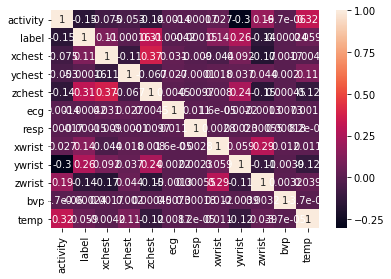

In [20]:
matrix_correlation = dfalldataframes.corr()

plt.figure()
seaborn.heatmap(matrix_correlation,annot=True)
plt.show()

## 3. Classification 

## 3.1. On récupère notre X et y

In [21]:
X = dfalldataframes[['IDSubject','AGE','SPORT','label','xchest','ychest','zchest','ecg','resp','xwrist','ywrist','zwrist','bvp','temp']]
y = dfalldataframes[['activity']]

X.shape, y.shape

((517956, 14), (517956, 1))

Pour passer le y en array 1d on utilise y.ravel()

## 3.2. On divise en jeu de test et apprentissage

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), random_state=1234)

In [23]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((388467, 14), (129489, 14), (388467,), (129489,))

On retrouve bien le splitage ratio

In [24]:
[tuple_[0]/X.shape[0] for tuple_ in (X_train.shape, X_test.shape, y_train.shape, y_test.shape)]

[0.75, 0.25, 0.75, 0.25]

In [25]:
performances = dict()

Il est préférable de standardiser les valeurs même pour une LinearRegression ce n'est pas obligatoire 

In [26]:
scaler   = StandardScaler().fit(X_train)
X_train  = scaler.transform(X_train)
X_test   = scaler.transform(X_test)

### On crée une fonction de tout ceci afin de pouvoir l'utiliser après

In [27]:
def get_score(algorithme, X_train, X_test, y_train, y_test, display_graph=False, display_options=True):
    if display_options:
        print("fitting :\n"+ str(algorithme))
        print("X_train:{} , X_test:{} ,  y_train:{} ,  y_test:{}".format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))
    modele = algorithme.fit(X_train, y_train)
    score  = modele.score(X_test, y_test)
    if display_graph:
        import matplotlib.pyplot as plt
        plt.scatter(x=y_test, y=algorithme.predict(X_test)) ## Predictions against True values
    return score

## 3.3. DecisionTreeClassifier

In [50]:
algorithme = DecisionTreeClassifier()
score = get_score(algorithme, X_train, X_test, y_train, y_test)
performances[algorithme] = score

fitting :
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
X_train:(388467, 14) , X_test:(129489, 14) ,  y_train:(388467,) ,  y_test:(129489,)


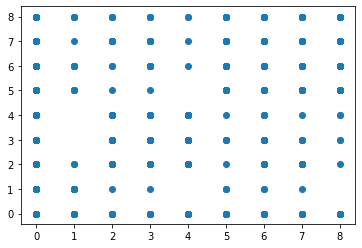

In [51]:
plt.scatter(x=y_test, y=algorithme.predict(X_test))

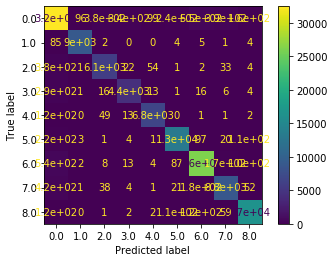

In [52]:
plot_confusion_matrix(algorithme, X_test, y_test)

## 3.4. RandomForestClassifier

In [47]:
hyperparametres = { 'n_estimators':30 }
algorithme = RandomForestClassifier(**hyperparametres)
score = get_score(algorithme, X_train, X_test, y_train, y_test)
performances[algorithme] = score

fitting :
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
X_train:(388467, 14) , X_test:(129489, 14) ,  y_train:(388467,) ,  y_test:(129489,)


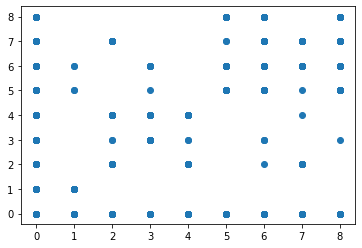

In [48]:
plt.scatter(x=y_test, y=algorithme.predict(X_test))

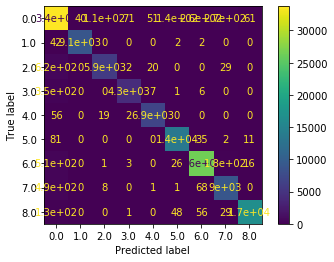

In [49]:
plot_confusion_matrix(algorithme, X_test, y_test)

## 3.5. ExtraTreesClassifier

In [35]:
algorithme = ExtraTreesClassifier()
score      = get_score(algorithme, X_train, X_test, y_train, y_test)
performances[algorithme] = score

fitting :
ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
X_train:(388467, 14) , X_test:(129489, 14) ,  y_train:(388467,) ,  y_test:(129489,)


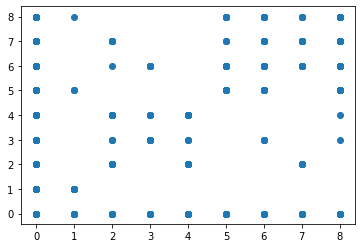

In [37]:
plt.scatter(x=y_test, y=algorithme.predict(X_test))

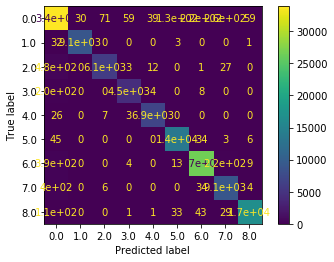

In [42]:
plot_confusion_matrix(algorithme, X_test, y_test)

## 3.6. AdaBoostClassifier

In [43]:
algorithme = AdaBoostClassifier(n_estimators=100, random_state=1234)
score      = get_score(algorithme, X_train, X_test, y_train, y_test)
performances[algorithme] = score

fitting :
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=1234)
X_train:(388467, 14) , X_test:(129489, 14) ,  y_train:(388467,) ,  y_test:(129489,)


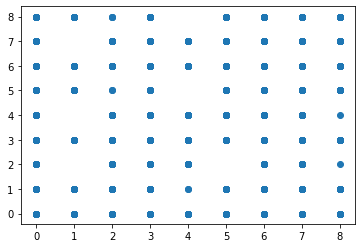

In [44]:
plt.scatter(x=y_test, y=algorithme.predict(X_test))

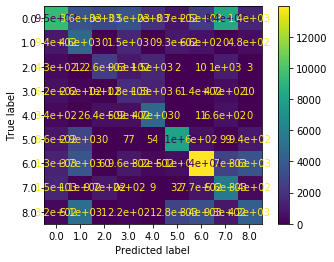

In [46]:
plot_confusion_matrix(algorithme, X_test, y_test)

## 3.7 . SVC

In [ ]:
algorithme = SVC(gamma='auto')
score = get_score(algorithme, X_train, X_test, y_train, y_test)
performances[algorithme] = score

In [ ]:
plt.scatter(x=y_test, y=algorithme.predict(X_test))

In [ ]:
plot_confusion_matrix(algorithme, X_test, y_test)

## 3.8. Cross Validation

results = cross_val_score(NOMALGO(), X, y) 
display(results, results.mean(), results.std())

### On va utiliser la cross validation afin de valider la robustesse de notre modèle. Cela évite donc le coup de chance


results = cross_val_score(NOMALGO(), X, y, cv=KFold(shuffle=True, n_splits=5))
display(results, results.mean(), results.std())

## 3.9. Comparaison des résultats de nos modèles

In [53]:
dico_ordonne = OrderedDict(performances)
df = pd.DataFrame()
df["perf"] = dico_ordonne.values()
df["algo"] = dico_ordonne.keys()
df['nom_algo'] = df.algo.apply(lambda algo: str(algo).split('(')[0])
df.set_index('nom_algo', inplace=True)
df

,perf,algo
nom_algo,,
DecisionTreeClassifier,0.953803,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
RandomForestClassifier,0.968345,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
ExtraTreesClassifier,0.976415,"(ExtraTreeClassifier(ccp_alpha=0.0, class_weig..."
AdaBoostClassifier,0.425372,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
RandomForestClassifier,0.970183,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
DecisionTreeClassifier,0.954436,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."


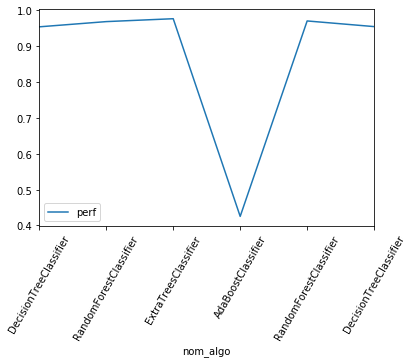

In [54]:
df[["perf"]].plot(kind='line', rot=60)

# 4. API

In [55]:
scaler =  StandardScaler()
X = scaler.fit_transform(X)

In [58]:
lm = ExtraTreesClassifier()
lm.fit(X, y)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

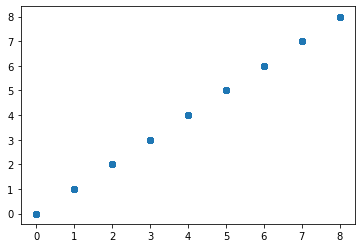

In [59]:
plt.scatter(y, lm.predict(X))

In [60]:
joblib.dump(lm, "model_simple.sav")

['model_simple.sav']

In [61]:
joblib.dump(scaler, "scaler.sav")

['scaler.sav']